# Introduction
The objective of this notebook is to discretize HRUs in a watershed and create a weighting matrix that describes the hillslope-stream network connectivity in a catchment. This notebook is meant to replace the spatial discretization workflow (*DynatopSpatialFunctionExplicitReaches*) for the modified dynamic TOPMODEL described by Mahoney et al. (2022) *J. Hydrol*. 

To run this notebook, it is necessary to first install kernels for Python and R and install arcpy to the environment from which the notebook is run (see instructions [here](https://github.com/tyler-mahoney/modeling-streamflow-permanence/blob/main/arcpy-setup.ipynb)). Instances when switching the kernel is necessary will be denoted in a Markdown cell. 

## Step 1: Load in Necessary Libraries

In [1]:
# Import relevant libraries and output the current working directory

import arcpy
import os
import math
import pandas 
import numpy
from arcpy.sa import *
from arcpy import env
from IPython.display import display
arcpy.env.overwriteOutput = True

env.workspace = 'C:/Users/david/OneDrive/Desktop/Mahoney Research/2-Mahoney-EPA/modeling-streamflow-permanence/SpatialInputData/LittleMillseat.gdb' 


## Step 2: Import Rasters and calculate TWI
   
Note: This code will calculate the TWI using the D8 flow direction. It is possible to import a DINF or MFD raster here as well and use this to run the analysis, assuming that it is already in the GDB. 

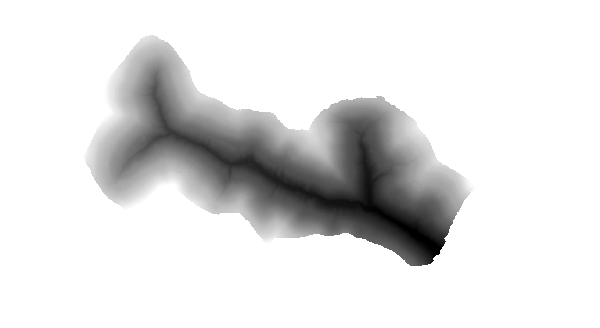

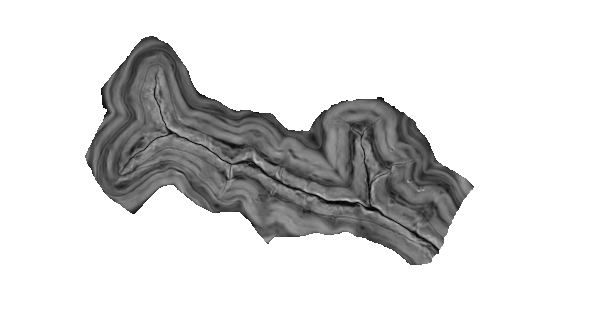

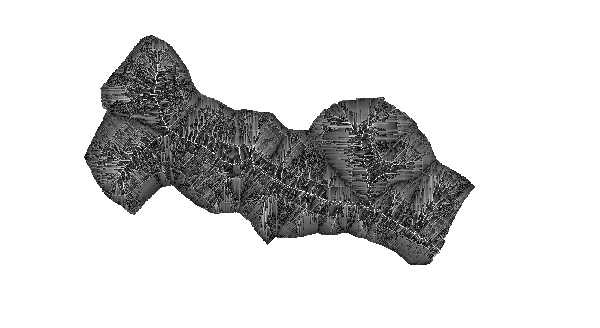

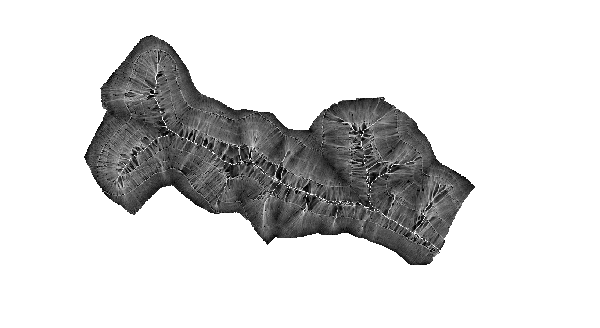

In [3]:
# Load in rasters 
LM_DEM = Raster('LM_1meterDEM')
#LM_HRU = Raster('FallingRockHRUs')
LM_fac_dinf = Raster('LM_fac_dinf')

# Calculate rasters
LM_Slope = Slope(LM_DEM, "DEGREE")
LM_Slope = LM_Slope*math.pi/180
LM_fill = Fill(LM_DEM)
LM_fdr = FlowDirection(LM_fill, "Normal")
LM_fac = FlowAccumulation(LM_fdr)


# Calculate the TWI
LM_twi = Ln(((LM_fac+1))/Con(LM_Slope > 0, Tan(LM_Slope),0.0001))
LM_twi_dinf = Ln(((LM_fac_dinf+1))/Con(LM_Slope > 0, Tan(LM_Slope),0.0001))

# Save the rasters tp the environment (note an error will occur if these have already been saved)
LM_twi.save('C:/Users/david/OneDrive/Desktop/Mahoney Research/2-Mahoney-EPA/modeling-streamflow-permanence/SpatialInputData/LM_twi.tif')
LM_twi_dinf.save('C:/Users/david/OneDrive/Desktop/Mahoney Research/2-Mahoney-EPA/modeling-streamflow-permanence/SpatialInputData/LM_twi_dinf.tif')

# Display the rasters 
display(LM_fill)
display(LM_Slope)
display(LM_twi)
display(LM_twi_dinf)

## Step 3: Create a HRU raster based on the TWI, soils, and other data using R
Now, we will switch over to R and create an HRU map of for the watershed. 
**Make sure to switch the kernel from python (esri) to R**

### Step 3.1: Install libraries and read in raster files
Relevant libraries include spatial and raster libraries, cluster analyses, and tidyverse. Note, we are creating HRUs with the following rasters: 
- DEM
- Soils 
- TWI

Other relevant layers that *could* be used include: 
- LULC 
- Ksat
- Porosity
- Aspect
- Curvature 
- Temperature
- Precipitation

Note: there is some degree of customizability here. Any relevant layer could be added.

In [1]:
# Load in Libraries
library(sp)
library(raster)
library(dynatopmodel)
library(topmodel)
library(ecbtools)
library(cluster)
library(factoextra)
library(tidyverse)
library(NbClust)
library(basicClEval)
library(ggplot2)
library(mapview)
library(reticulate)

# Read in the rasters that we'd need for HRU creation
FR.dem <- raster('SpatialInputData/fr1meterDEM.tif')
FR.soils <- raster('SpatialInputData/FRSoils1mMask.tif')
FR.TWI.dinf <- raster('C:/Users/david/OneDrive/Desktop/Mahoney Research/2-Mahoney-EPA/modeling-streamflow-permanence/SpatialInputData/fr_twi_dinf.tif')
FR.TWI.dinf[FR.TWI.dinf==0] <- NA # We do this because the areas outside of the raster have a value 0 and we want these to be set to NA


Warning message:
"package 'cluster' was built under R version 4.0.5"
Warning message:
"package 'factoextra' was built under R version 4.0.5"
Loading required package: ggplot2

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa

Warning message:
"package 'tidyverse' was built under R version 4.0.5"
-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.1 --

v tibble  3.1.7     v dplyr   1.0.9
v tidyr   1.2.0     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1
v purrr   0.3.4     

Warning message:
"package 'tidyr' was built under R version 4.0.5"
Warning message:
"package 'readr' was built under R version 4.0.3"
Warning message:
"package 'forcats' was built under R version 4.0.5"
-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x tidyr::extract() masks raster::extract()
x dplyr::filter()  masks stats::filter()
x dpl

### Step 3.2: Run K means cluster analysis

Here, we are creating HRUs using a k-means cluster analysis. This is based on methods recommended from [Chaney et al. 2016](https://doi.org/10.1002/hyp.10891). One alternatively could superimpose layers, but we choose to define HRUs based on cluster analysis given the benefits of the k-means approach discussed by Chaney et al. 2016.

Given the spatial scale of the study watershed (~1 km^2), we aren't combining the Kmeans analysis with terrain analysis yet. This is more of a 'brute force' Kmeans approach. 

There are a number of customizable components of this step:
- We 'cut' each raster into a certain representative number of bins.
- Binning the raster layers assists with better-simplifying the landscape surface, based on trial and error. 
- We choose 4 cuts for the elevation bands and 4 cuts for the number of TWI raster bins. 
- One could specify any number of cuts based on the desired simplification of the raster surface.
- There are three soil types in the test watershed, so this layer is more or less already cut. 
- 'k' represents the number of HRUs that should be generated. How many HRUs should we use? 
- See the elbow plot below. When the reduction in total variability of each HRU begins to decrease less rapidly, that is generally the number of HRUs that should be specified based on Cluster Analysis. 
- There are a number of approaches that could be used to choose 'k' however. See Chaney's paper.

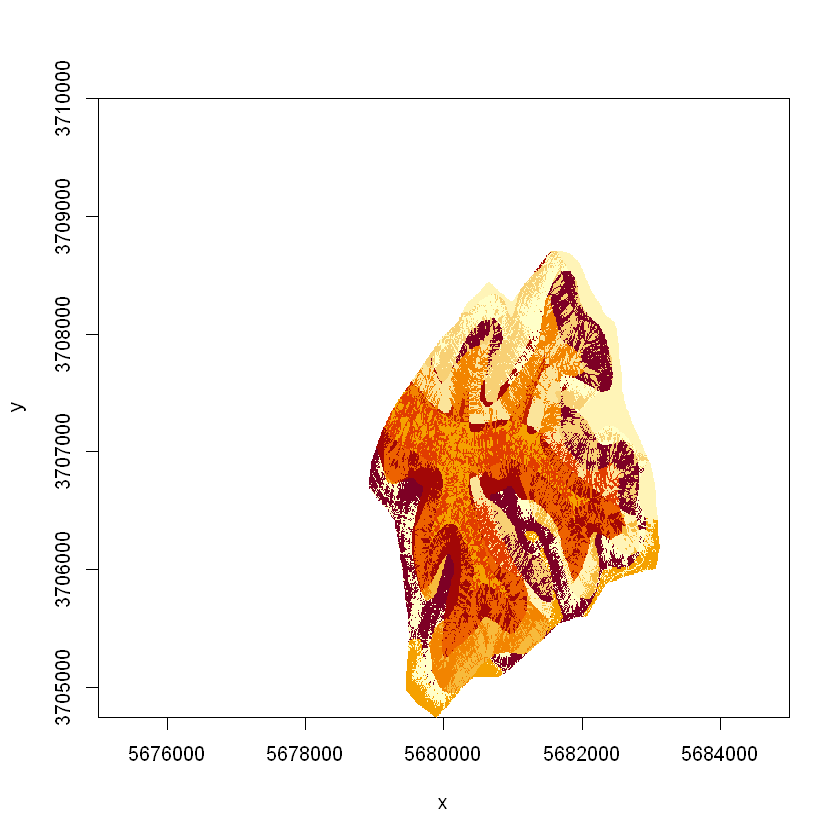

In [9]:
## Run Kmeans to create HRUs using elevation bands, TWI, and soils data
set.seed(123)

# Cut the layers into desired number of bins 
FR.elev.bands <- cut(FR.dem, 4)
FR.TWI.dinf.cut <- cut(FR.TWI.dinf,4)

# Combine the rasters into a single stack
FR.stack <- stack(FR.TWI.dinf.cut, FR.soils, FR.elev.bands) 

# Run the Kmeans analysis - k is the number of clusters that will be generated.
FR.HRU <- raster.kmeans(FR.stack, k = 20, iter.max=10, nstart = 10, geo = T, geo.weight = 1)

image(FR.HRU)

### Step 3.3: Create an elbow plot showing the number of HRUs which should be created 
The total within sum of squares for each cluster is used to estimate the variability for each iteration. 

Note: this code takes a decent amount of time to run.

Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 20786250)"
Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 20786250)"


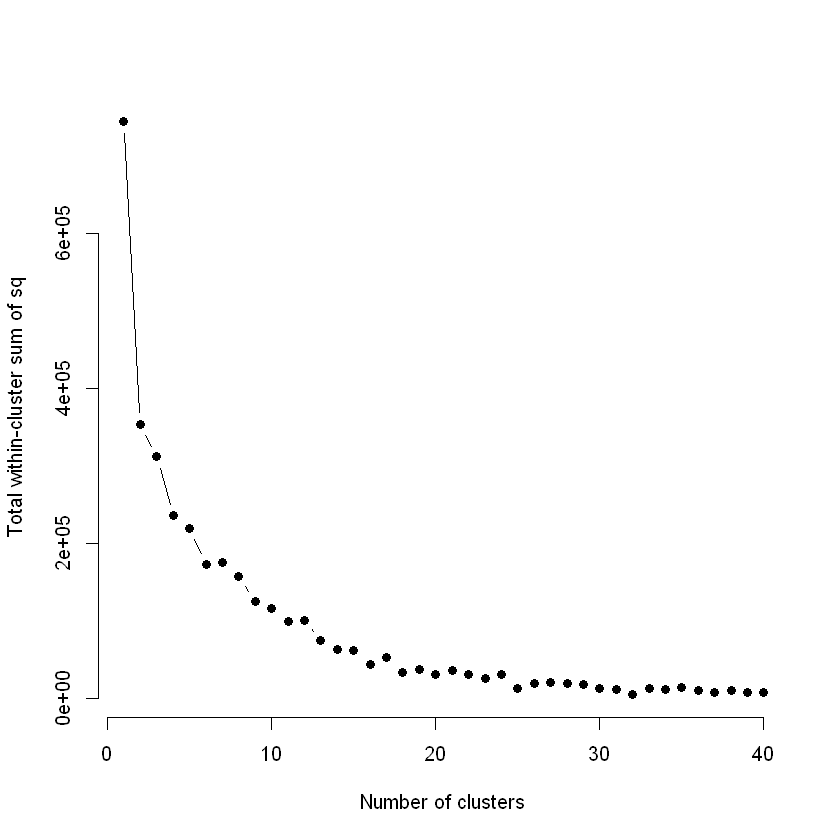

In [4]:
wss.raster <- function(k) {
    # Run the K-means analysis
    FR.kmeans.raster <- raster.kmeans(FR.stack, k, iter.max=10, nstart = 10, geo = T, geo.weight = 1)
    
    # Load in the data and get into vector form
    FR.HRU.vector <- data.frame('hru' = as.vector(FR.kmeans.raster))
    FR.TWI.vector <- data.frame('TWI' = as.vector(FR.TWI.dinf.cut))
    FR.soils.vector <- data.frame('soils' = as.vector(FR.soils))
    FR.elev.bands.vector <- data.frame('Elev.bands' = as.vector(FR.elev.bands))
    
    # Put the raster vectors into a cleaned data frame
    FR.rasters.df <- data.frame(FR.HRU.vector,FR.TWI.vector,FR.soils.vector,FR.elev.bands.vector)
    FR.rasters.df.clean <- FR.rasters.df[complete.cases(FR.rasters.df),]
  
    # Calculate the within cluster sum of squares
    within.ss <- wcss(FR.rasters.df.clean[,-1],FR.rasters.df.clean[,1])
    
    # Return the total within cluster sum of squares
    return(within.ss$WCSS)
}

set.seed(123)

# Compute and plot within sum squares for k = 1 to k = 40
k.values <- 1:40

# extract within sum of squares for 1-40 clusters
wss_values <- map_dbl(k.values,wss.raster)

# plot within sum of squares vs cluster (HRU) number
plot(k.values,wss_values,type='b',pch=19,frame=F,xlab='Number of clusters',ylab='Total within-cluster sum of sq')


### Step 3.4: Plot the clusters for reference 
We will look at the various clusters created and how they appear within relation to one another 

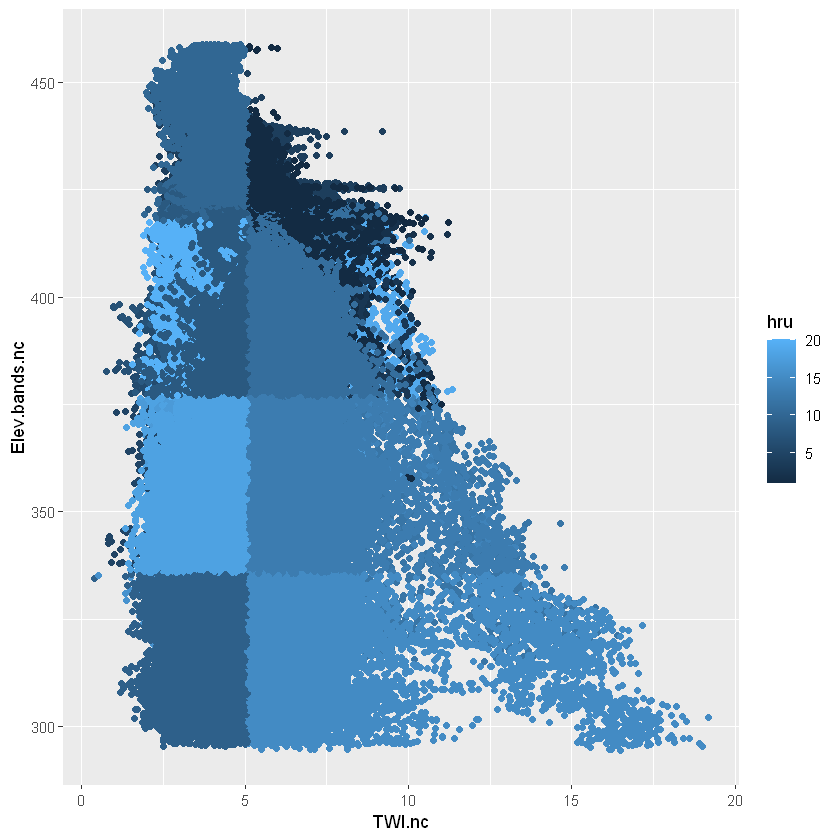

In [10]:
# Load in the data and get into vector form
FR.HRU.vector <- data.frame('hru' = as.vector(FR.HRU))
FR.TWI.vector <- data.frame('TWI' = as.vector(FR.TWI.dinf.cut))
FR.TWI.nc.vector <- data.frame('TWI.nc'=as.vector(FR.TWI.dinf))
FR.soils.vector <- data.frame('soils' = as.vector(FR.soils))
FR.elev.bands.vector <- data.frame('Elev.bands' = as.vector(FR.elev.bands))
FR.elev.bands.nc.vector <- data.frame('Elev.bands.nc' = as.vector(FR.dem))

# Put the raster vectors into a cleaned data frame
FR.rasters.df <- data.frame(FR.HRU.vector,FR.TWI.vector,FR.TWI.nc.vector,FR.soils.vector,FR.elev.bands.vector,FR.elev.bands.nc.vector)
FR.rasters.df.clean <- FR.rasters.df[complete.cases(FR.rasters.df),]

# Plot the elev bands vs twi with HRU as color
ggplot(data=FR.rasters.df.clean, aes(x=TWI.nc,y=Elev.bands.nc,col=hru))+geom_point()

# Note - the straight lines are due to the cuts that we creted. We could just as easily not include these cuts and other geometries would come through

### Step 3.5: Sort the HRUs by TWI and add in the stream raster 
In this step, we will first sort HRUs by TWI value (high TWI = high number HRU), then we will "burn in" a stream network that has been previously delineated. This represents the geomorphic stream channel, to which the watershed uplands will contribute water. 

The raster need to have the following characteristics: 
- The resolution, extent, and snapping should be the same as the DEM
- The raster is derived from a Flow accumulation raster with an upstream contributing area threshold applied
- The threshold should create a stream network that is similar to the stream mapped in the field 
- The reaches should be created using the stream link/order tools in ArcGIS
- The shapefile created from these stream tools should be buffered such that a contiguous stream network raster can be created 
- Here, a buffer of 2 cell widths was used (~1.524 * 2 m)

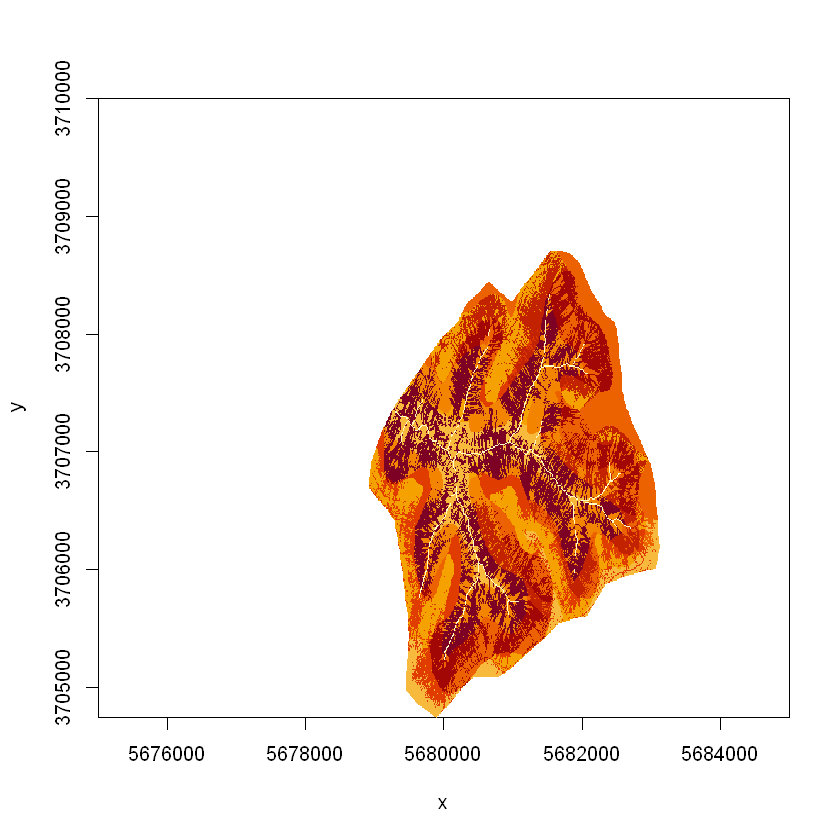

In [11]:
## Calculate the mean TWI for each HRU - relabel the HRUs such that high valued TWI is the highest number HRU and low valued TWI is the lowest HRU
## Note - this isn't necessary for dynatopmodel, but may be necessary for dynatop
mean.twi <- data.frame(matrix(nrow=length(unique(FR.HRU)),ncol=5))
names(mean.twi) <- c('HRU.name','atb.bar.unsort','id.new','atb.bar','id')
mean.twi$HRU.name <- unique(FR.HRU)

FR.hillslope.hru.matrix <- as.matrix(FR.HRU)
TWI.dinf.matrix <- as.matrix(FR.TWI.dinf)

for (i in 1:length(unique(FR.HRU))) {
  mean.twi$atb.bar.unsort[i] <- mean(TWI.dinf.matrix[which(FR.hillslope.hru.matrix==unique(FR.HRU)[i])])
}

mean.twi$atb.bar <- sort(mean.twi$atb.bar.unsort,decreasing=F)
mean.twi$id.new <- match(mean.twi$atb.bar.unsort,mean.twi$atb.bar)
mean.twi$id <- 1:length(unique(FR.HRU))

reclassify.matrix <- data.frame(matrix(nrow=length(unique(FR.HRU)),ncol=2))
names(reclassify.matrix) <- c('is','becomes')
reclassify.matrix$is <- mean.twi$HRU.name
reclassify.matrix$becomes <- mean.twi$id.new

FR.HRU <- reclassify(FR.HRU,reclassify.matrix)

## Overlay the stream network atop the FR Hru raster
FR.stream <- raster('SpatialInputData/FR_stream_network.tif')
FR.stream[FR.stream==0] <- NA
FR.HRU <- FR.HRU*10+max(max(unique(FR.stream)),100)               # Uniquely identifying the upland HRUs
FR.HRU[FR.stream>0] <- FR.stream[FR.stream>0]                     # Identify the cells from the HRU raster that overlap with the stream, set those equal to the reach number 
writeRaster(FR.HRU,"SpatialInputData/FR_HRU.tif",overwrite=T)

image(FR.HRU)
twi.zonal <- zonal(x=FR.TWI.dinf,z=FR.HRU,fun='mean')
FR.TWI.zonal <- reclassify(FR.HRU,twi.zonal)

image(FR.TWI.zonal)

In [12]:
(unique(FR.HRU))

length(unique(FR.stream))

[1]   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19
[20]  20  21  22  23  24  25  26  27  28  29  30  31  32  33 110 120 130 140 150
[39] 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300

[1] 33

### Step 3.6 Visualize the HRU/Stream Raster

Note - I'm going to do this with the mapview function in R, but this could be done using the arcpy and arcgis modules in python. The reason for not using python is because if we interrupt the kernel we'll have to reload variables from above

In [22]:
library(mapview)
mapviewOptions(fgb = FALSE)
mapview(Fra)

Warning message in rasterCheckSize(x, maxpixels = maxpixels):
"maximum number of pixels for Raster* viewing is 5e+05 ; 
the supplied Raster* has 2102000 
 ... decreasing Raster* resolution to 5e+05 pixels
 to view full resolution set 'maxpixels =  2102000 '"
Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO"):
"Discarded ellps WGS 84 in CRS definition: +proj=merc +a=6378137 +b=6378137 +lat_ts=0 +lon_0=0 +x_0=0 +y_0=0 +k=1 +units=m +nadgrids=@null +wktext +no_defs"
Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO"):
"Discarded datum WGS_1984 in CRS definition"
Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO"):
"Discarded ellps WGS 84 in CRS definition: +proj=merc +a=6378137 +b=6378137 +lat_ts=0 +lon_0=0 +x_0=0 +y_0=0 +k=1 +units=m +nadgrids=@null +wktext +no_defs"
Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO"):
"Discarded datum WGS_1984 in CRS definition"


## Step 4: Create a flow weighting raster
In this step, we will return the HRU value of the cell that is immediately downstream of each cell in the watershed. 

### Step 4.1: Calcualte the downstream matrix

This process returns the value of the HRU immediately downstream of a cell. 
This algorithm strictly works for a D8 flow direction, but could be expanded for DInf at a later time. 

**Make sure to switch over to R kernel**

In [13]:
library(sp)
library(raster)

FR.fdr <- raster('SpatialInputData/fr_fdr')
#FR.HRU <- raster('SpatialInputData/FR_HRU.tif')

HRU.matrix <- as.matrix(FR.HRU)
fdr.matrix <- as.matrix(FR.fdr)

fdr.downstream.matrix <- matrix(nrow=nrow(HRU.matrix),ncol=ncol(HRU.matrix))

for (i in 1:nrow(HRU.matrix)) {
  for (j in 1:ncol(HRU.matrix)) {
    if (is.na(fdr.matrix[i,j])) {
      fdr.downstream.matrix[i,j] <- NA
    } else {
      if (fdr.matrix[i,j]==1) {
        fdr.downstream.matrix[i,j] <- HRU.matrix[i,j+1]
      } else if (fdr.matrix[i,j]==2) {
        fdr.downstream.matrix[i,j] <- HRU.matrix[i+1,j+1]
      } else if (fdr.matrix[i,j]==4) {
        fdr.downstream.matrix[i,j] <- HRU.matrix[i+1,j]
      } else if (fdr.matrix[i,j]==8) {
        fdr.downstream.matrix[i,j] <- HRU.matrix[i+1,j-1]
      } else if (fdr.matrix[i,j]==16) {
        fdr.downstream.matrix[i,j] <- HRU.matrix[i,j-1]
      } else if (fdr.matrix[i,j]==32) {
        fdr.downstream.matrix[i,j] <- HRU.matrix[i-1,j-1]
      } else if (fdr.matrix[i,j]==64) {
        fdr.downstream.matrix[i,j] <- HRU.matrix[i-1,j]
      } else if (fdr.matrix[i,j]==128) {
        fdr.downstream.matrix[i,j] <- HRU.matrix[i-1,j+1]
      } else {
        fdr.downstream.matrix[i,j] <- NA
      }
    }
  }
}



### Step 4.2: Calculate the explicit weighting matrix which shows the number of cells from one HRU to contribute to downstream HRUs. 
In this step, we will create a weighting matrix that outputs the proportion of flow generated in one cell that will be redistributed to downstream cells. 

This works by: 
- identifying all cells that belong to a certain HRU
- identifying all cells which belong to a downstream HRU
- identifying the cells where both of these conditions are true
- returning the number of cells where both are true 

In this regard, the output will be all cells which belong to HRU i that flow into HRU j. 

In [2]:
print('Running weighting matrix...')

downstream.weighting.matrix <- matrix(nrow=length(unique(FR.HRU)),ncol=length(unique(FR.HRU)))
start.time <- Sys.time()
for (i in 1:length(unique(FR.HRU))) {
  for (j in 1:length(unique(FR.HRU))) {
    print(unique(FR.HRU)[i])
    downstream.weighting.matrix[i,j] <- length(which((HRU.matrix==unique(FR.HRU)[i])&(fdr.downstream.matrix==unique(FR.HRU)[j])))
  }
}
end.time <- Sys.time()
end.time-start.time

options("scipen"=100, "digits"=5)

rownames(downstream.weighting.matrix) <- unique(FR.HRU)
colnames(downstream.weighting.matrix) <- unique(FR.HRU)

weighting.matrix <- downstream.weighting.matrix/rowSums(downstream.weighting.matrix)

rownames(weighting.matrix) <- unique(FR.HRU)
colnames(weighting.matrix) <- unique(FR.HRU)


[1] "Running weighting matrix..."
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 2
[1] 3
[1] 3
[1] 3
[1] 3
[1] 3
[1] 3
[1] 3
[1] 3
[1] 3
[1] 3
[1] 3
[1] 3
[1] 3
[1] 3
[1] 3
[1] 3
[1] 3
[1] 3
[1] 3
[1] 3
[1] 3
[1] 3
[1] 3
[1] 3
[1] 3
[1] 3
[1] 3
[1] 3
[1] 3
[1] 3
[1] 3
[1] 3
[1] 3
[1] 3
[1] 3
[1] 3
[1] 3
[1] 3
[1] 3
[1] 3
[1] 3
[1] 3
[1] 3
[1] 3
[1] 3
[1] 3
[1] 3
[1] 3
[1] 3
[1] 3
[1] 3
[1] 3
[1] 3
[1] 4
[1] 4


Time difference of 39.28576 mins

In [4]:
# Write out the weighting matrix - the previous code takes a long time to run (but only needs to be run once)

write.csv(weighting.matrix,"explicit_weighting_matrix.csv")

In [4]:
# Ensure that all of the rows in the matrix sum to 1:
weighting.matrix <- read.csv('explicit_weighting_matrix.csv')
rowSums(weighting.matrix)

[1]   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20
[20]  21  22  23  24  25  26  27  28  29  30  31  32  33  34 111 121 131 141 151
[39] 161 171 181 191 201 211 221 231 241 251 261 271 281 291 301

## Step 5: Create the Groups Matrix

In the final step, we will create an a "Groups" matrix which will specifiy the initial parameters for dynamic TOPMODEL.

Note - I did notice some differences between how the atb.bar was calculated with dynatopmodel and this approach. It is related to how the HRUs are discretized. There is more variability with the dynatopmodel approach. 

Items we will need to include in the table: 
- id - the ID of the channel, typically channels are ranked 0-100 and HRUs are ranked based on TWI with ID > 100
- tag - same as id
- chan.no - the channel number (note - only for IDs classified as channels)
- area_pc - the percent area that the HRU takes up
- area - the area m^2 that the HRU takes up
- sbar - the average slope of the HRU (m/m)
- atb.bar - the average TWI for the HRU
- gauge.id - the rain gauge contributing to the HRU
- catch.id - the catchment in which the HRU is situated
- srz_max - maximum depth of root zone parameter value initialized as 0.1
- ln_t0 - ln t0 parameter value initialized as 7
- m - exponential decline of transmissivity parameter initialized as 0.01  
- srz0 - initial root zone storage parameter initialized as 0
- td - td parameter initialized as 1
- vchan - v chan parameter (for channels only) parameterized as 1000
- vof - overland v parameter (for HRUs only) parameterized as 100
- k0 - k0 parameter initialized as 1e+8
- CD - CD parameter (unused) initialized as 0.1
- sd_max - sd_max parameter initialized as 0.5
- pe_fact - potential evapotranspiration factor used to scale PET, initialized as 1
- vof_fact - vof factor initialized as 1
- rain_fact - rain factor used to scale precip amount, initialized as 1 
- mann.n - mannings n initialized as 0.01
- S0 - initial slope, parameterized as 0.1
- ex_max - ex max parameterized as 1

In [14]:
groups <- data.frame(matrix(nrow=length(unique(Fr.HRU)),ncol=26))
names(groups) <- c('id','tag','chan.no','order','area_pc','area','sbar','atb.bar','gauge.id','catch.id','srz_max','ln_t0',
                   'm','srz0','td','vchan','vof','k0','CD','sd_max','pe_fact','vof_fact','rain_fact','mann.n','S0','ex_max')
groups$id <- unique(Fr.HRU)
groups$tag <- unique(Fr.HRU)
groups$chan.no[1:length(unique(Fr.stream))] <- unique(Fr.stream)
groups$order <- 1:length(unique(Fr.HRU))
groups$area_pc <- sapply(X=groups$id,FUN=area_cell,raster.matrix=HRU.matrix)/sum(!is.na(HRU.matrix))*100
groups$area <- groups$area_pc*sum(!is.na(HRU.matrix))*cell.size^2/1000/1000/100
groups$sbar <- zonal(x=Fr.slope,z=Fr.HRU,fun='mean')[,2]
groups$atb.bar[(1+length(unique(Fr.stream))):length(unique(Fr.HRU))] <- zonal(x=TWI.dinf,z=Fr.HRU,fun='mean')[(1+length(unique(Fr.stream))):length(unique(Fr.HRU)),2]
groups$gauge.id <- 1
groups$catch.id <- 1
groups$srz_max <- 0.1
groups$ln_t0 <- 7
groups$m <- 0.01
groups$srz0 <- 0
groups$td <- 1
groups$vchan[1:length(unique(Fr.stream))] <- 1000
groups$vof[(1+length(unique(Fr.stream))):length(unique(Fr.HRU))] <- 100
groups$k0 <- 1e+8
groups$CD <- 0.1
groups$sd_max <- 0.5
groups$pe_fact <- 1
groups$vof_fact <- 1
groups$rain_fact <- 1
groups$mann.n <- 0.01
groups$S0 <- 0.1
groups$ex_max <- 1

ERROR: Error in `$<-.data.frame`(`*tmp*`, id, value = 1:20): replacement has 20 rows, data has 53


[1] NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA
[26] NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA NA
[51] NA NA NA